### Part 1: importing necessary libraries

In [17]:
# Importing necessary libraries for image processing and visualization
import os
import numpy as np
import matplotlib.pyplot as plt

# for part 3 and 4
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.filters import gaussian, sobel
from skimage.exposure import histogram

# for part 5

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

### Part 2: opening image files

In [3]:
# This is the folders handling that I do with my files, you have to adapt it based on the organization of your files
folder = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
scope_name = 'Tweez scope'
path_scope = os.path.join(folder, scope_name)
exp_date = '2023_11_15'
path = os.path.join(path_scope, exp_date)
folder_masks = 'contour_masks'
pos = 0

In [4]:
# this file name changes depending on the date and machine that the experiment was performed on

fname = f'{exp_date}_10x_1.0x_pLPT20&41_TiTweez_Pos{pos}.ome.tif'
#fname = f'{exp_date}_10x_1.0x_pLPT20&41_Ti_Pos{pos}.ome.tif'
#fname = f'{exp_date}_10x_1.0x_pLPT119&41_Ti_Pos{pos}.ome.tif'
#fname = f'{exp_date}_10x_1.0x_pLPT119&41_TiTweez_Pos{pos}.ome.tif'
#fname = f'{exp_date}_10x_1.0x_pLPT107&41_Ti_Pos{pos}.ome.tif'
#fname = f'{exp_date}_10x_1.0x_pLPT20&41_TiTweez_Pos{pos}.ome.tif'
#fname = f'{exp_date}_10x_1.0x_pLPT107&41_TiTweez_Pos{pos}.ome.tif'
#fname = f'{exp_date}_10x_1.0x_pAAA_TiTweez_Pos{pos}.ome.tif'
#fname = f'{exp_date}_10x_1.0x_pAAA_Ti_Pos{pos}.ome.tif'
fname_mask = 'mask_' + fname

In [5]:
# Loading image files
# Replace with the actual path to your TIFF file
image_path = os.path.join(path, fname)
mask_path = os.path.join(path, folder_masks, fname_mask)
im = imread(image_path)
mask = imread(mask_path)

# im.shape outputs the dimensions of the image: (nt, nx, ny, nc)
# nt: number of time points or frames in the image series
# nx, ny: dimensions of the image in pixels
# nc: number of channels (e.g., 3 for RGB, additional channels might include other fluorescence markers or phase contrast)

nt, nx, ny, nc = im.shape
print("Shape of the image array:", im.shape)

# the mask has shape (216, 1024, 1024) because it's just for one channel, so its 216 time points, one for each image of
# dimensions 1024, 1024
print("Shape of the image mask:", mask.shape)

# Selecting the phase contrast channel
# Adjust the index depending on the channels described (some images have 2 fluorescence channels and others have 3)
phase_images = im[:,:,:,3] if im.shape[3] > 3 else im[:,:,:,2]  # Check channel index based on your data structure

Shape of the image array: (216, 1024, 1024, 3)
Shape of the image mask: (216, 1024, 1024)


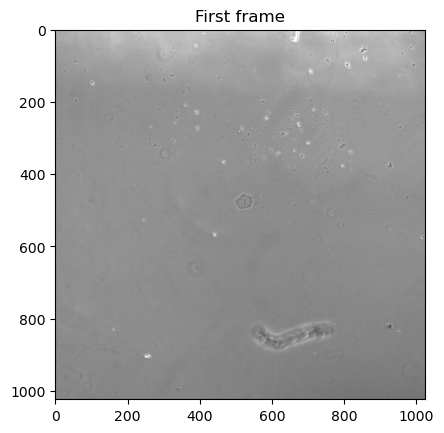

In [6]:
# show the first frame of the image of the phase contrast channel
plt.imshow(im[0,:,:,2], cmap='gray')
plt.title('First frame')
plt.show()

### Part 3: Simple computations and analysis with skimage

#### Example 1: Image resizing

Resizing is a common preprocessing steps for neural network inputs:

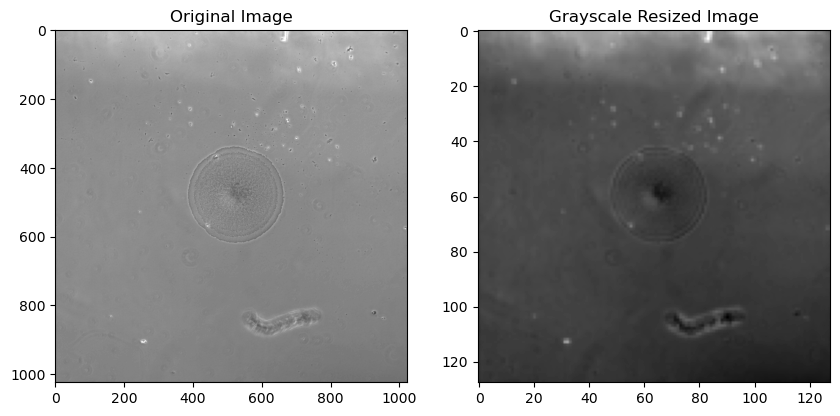

In [8]:
# Assuming `phase_images` is an array of images
# Select a single image to demonstrate resizing and grayscale conversion
t = 20
original_image = phase_images[t]

# Resize the image to 128x128 pixels
resized_image = resize(original_image, (128, 128))

# Display the original and processed images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(resized_image, cmap='gray')
axes[1].set_title('Grayscale Resized Image')
plt.show()


#### Example 2: Applying Gaussian filter

Gaussian filtering is used to smooth images, reducing noise and detail, which is useful before further processing:

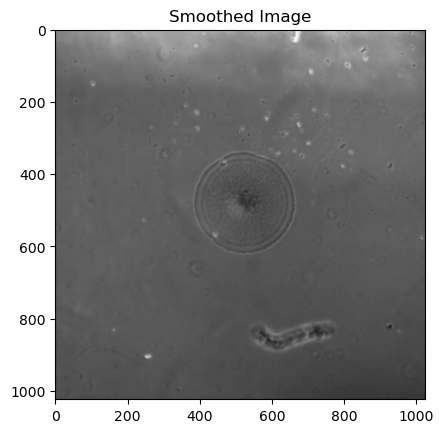

In [9]:
# Apply a Gaussian filter with a sigma of 1
smoothed_image = gaussian(original_image, sigma=2)

# Display the smoothed image
plt.imshow(smoothed_image, cmap='gray')
plt.title('Smoothed Image')
plt.show()

#### Example 3: Edge detection

Edge detection is a technique used to identify the boundaries of objects within images:

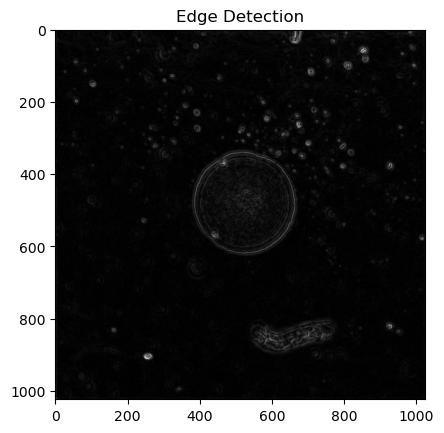

In [11]:
# Use the Sobel operator to find edges
edges = sobel(smoothed_image)

# Display the edge-detected image
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection')
plt.show()

#### Example 4: Histogram analysis

Analyzing the histogram of an image can provide insights into the distribution of pixel intensities:

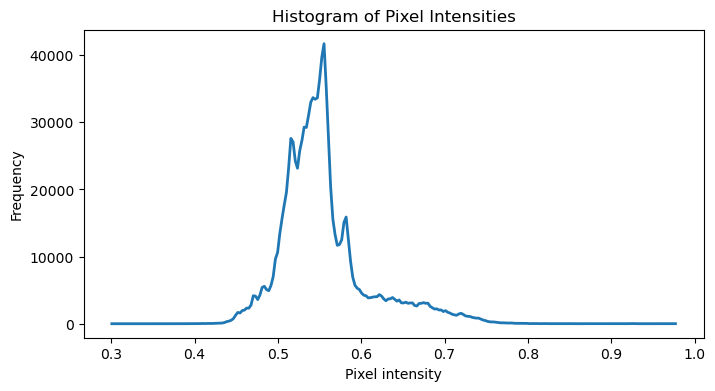

In [12]:
# Calculate the histogram of the grayscale image
hist, hist_centers = histogram(smoothed_image)

# Plot the histogram
plt.figure(figsize=(8, 4))
plt.plot(hist_centers, hist, lw=2)
plt.title('Histogram of Pixel Intensities')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.show()

### Part 4: Image processing workflow

#### Step 1: Read the image, we will use frame 20 as an example

In [19]:
# Comprehensive image processing workflow
t = 20
original_image = imread(image_path)[t,:,:,2]

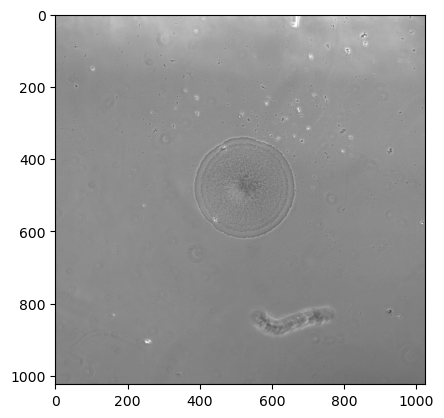

In [20]:
plt.imshow(original_image, cmap='gray')

#### Step 2: Clean the image if necessary (e.g., noise reduction)

In [21]:
cleaned_image = gaussian(original_image, sigma=1)

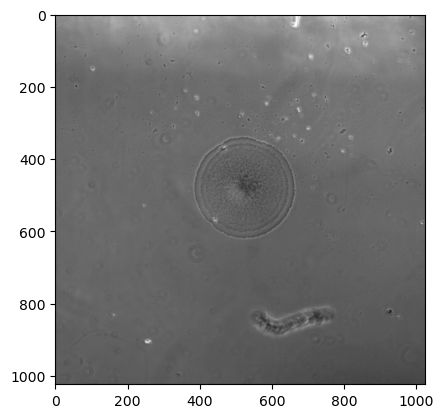

In [22]:
plt.imshow(cleaned_image, cmap='gray')

#### Step 3: Segment the image to create a mask

In [26]:
# we already have the masks, so we will use them
binary_mask = mask[t,:,:]

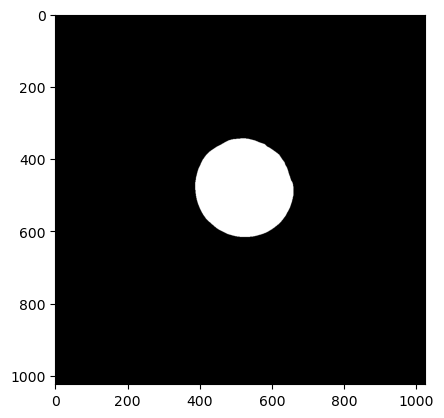

In [27]:
plt.imshow(binary_mask, cmap='gray')

#### Step 4: Analyze the image using the mask

In [28]:
masked_image = np.where(binary_mask, cleaned_image, 0)

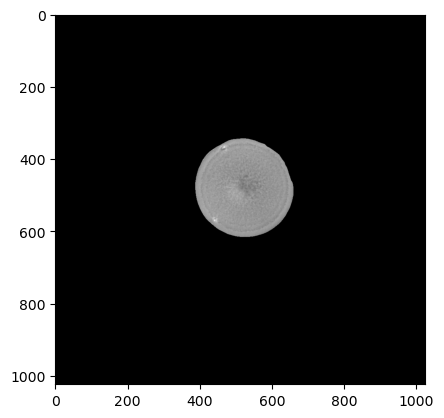

In [29]:
plt.imshow(masked_image, cmap='gray')

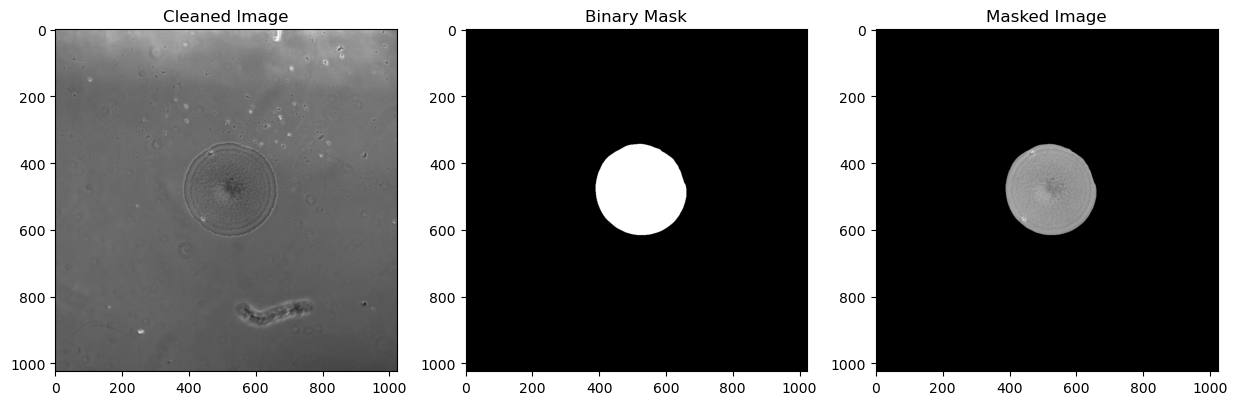

In [30]:
# Display the original, mask, and masked images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cleaned_image, cmap='gray')
axes[0].set_title('Cleaned Image')
axes[1].imshow(binary_mask, cmap='gray')
axes[1].set_title('Binary Mask')
axes[2].imshow(masked_image, cmap='gray')
axes[2].set_title('Masked Image')
plt.show()

### Part 5: Introduction to CNN with a practical example

#### Step 1: Prepare the dataset for training

For demonstration purposes, let’s assume we have the phase contrast image and its mask for $t = 20$, and I'll show how to prepare these for input into a CNN. We'll also discuss integrating additional data from a related public dataset.

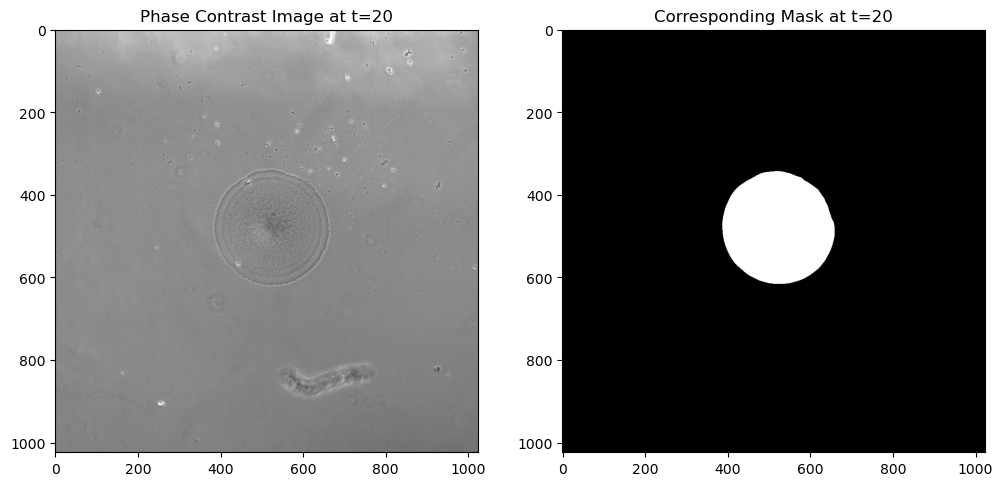

In [31]:
# Load images
phase_image = im[20, :, :, 2]  # Assuming channel 2 is phase contrast
mask_image = mask[20, :, :]       # Load mask for the same time step

# Display the images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(phase_image, cmap='gray')
ax[0].set_title('Phase Contrast Image at t=20')
ax[1].imshow(mask_image, cmap='gray')
ax[1].set_title('Corresponding Mask at t=20')
plt.show()

#### Step 2: Training the CNN

Assuming we're using additional data for training, let’s set up a simple CNN architecture. We will prepare a model for binary classification to determine whether image segments contain bacterial colonies.

In [32]:
# Define a CNN model that is suitable for large images
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(1024, 1024, 1), padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

print("Model architecture is set up to handle 1024x1024 pixel images.")

Model architecture is set up to handle 1024x1024 pixel images.


2024-05-16 12:22:14.258139: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Due to the large size of the images, using data augmentation and image generators is a good strategy to manage memory usage and introduce variability in the training data, which helps prevent overfitting.

In [33]:
# Set up data augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Example of using the generator (assuming you have train_images and train_labels prepared)
# Note: This is a placeholder. Implement data loading and preprocessing as required.
# history = model.fit(datagen.flow(train_images, train_labels, batch_size=8), epochs=25)

# Note on batch size:
# A smaller batch size is used here because of the high memory demand of large images.

### Part 6: Example of training a CNN

In [ ]:
# Define paths to your datasets
image_directory = '/path/to/phase_images/'
mask_directory = '/path/to/masks/'

# Load datasets
# For this example, let's assume we have lists of file paths: image_files and mask_files
# Here, we use a simple loading mechanism. In practice, you should implement robust data handling.
image_files = [image_directory + 'image_{}.tif'.format(i) for i in range(100)]
mask_files = [mask_directory + 'mask_{}.tif'.format(i) for i in range(100)]

# Load images and masks
images = np.array([imread(file, as_gray=True) for file in image_files])
masks = np.array([imread(file, as_gray=True) for file in mask_files])

# Normalize images
images = images / 255.0

# Reshape masks to fit the model output
masks = masks[..., np.newaxis]  # Add channel dimension

# Split the data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

#### Step 2: Configure the CNN Model
We will configure a CNN that is appropriate for the task of classifying image sectors with or without bacterial colonies:

In [34]:
# Define the CNN model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(1024, 1024, 1), padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

#### Step 3: Data Augmentation and Model Training
Use data augmentation to improve model generalizability:

In [37]:
# Data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model
history = model.fit(datagen.flow(train_images, train_masks, batch_size=8),
                    validation_data=(val_images, val_masks),
                    epochs=25)

#### Step 5: Visualizing Training Results
Plot the training and validation accuracy to evaluate the model:

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()